In [1]:
# ─── Standard Library ───────────────────────────────────────────────────────
import os
import re
import glob
import time
import struct
import random
import shutil
from datetime import datetime
from collections import Counter, OrderedDict
from concurrent.futures import ThreadPoolExecutor, as_completed
from pathlib import Path

# ─── Data Handling ──────────────────────────────────────────────────────────
import numpy as np
import pandas as pd

# ─── Visualization ──────────────────────────────────────────────────────────
import matplotlib.pyplot as plt
import seaborn as sns

# ─── Machine Learning & PyTorch ─────────────────────────────────────────────
import torch
from torch import nn, optim
from torch.nn import functional as F
from torch.nn.functional import softmax
from torch.utils.data import Dataset, DataLoader, Sampler, random_split
import torch.backends.cudnn as cudnn
from sklearn.svm import SVC, LinearSVC
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV

# ─── Computer Vision ────────────────────────────────────────────────────────
from torchvision import datasets, transforms, models
from torchvision.transforms.functional import pad
from torchvision.utils import save_image
from PIL import Image, UnidentifiedImageError
import cv2
from skimage import io, color
import timm  # For accessing pretrained models beyond torchvision

# ─── Metrics & Evaluation ───────────────────────────────────────────────────
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, confusion_matrix, ConfusionMatrixDisplay,
    classification_report
)

# ─── Progress Monitoring ────────────────────────────────────────────────────
from tqdm.auto import tqdm

# ─── Reproducibility ────────────────────────────────────────────────────────
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

In [2]:
# Connect to Google Drive - remember to make a shortcut of the "Patches" folder to "My Drive"
from google.colab import drive
drive.flush_and_unmount()
drive.mount('/content/drive')

Drive not mounted, so nothing to flush and unmount.
Mounted at /content/drive


In [3]:
# Upload zip file of patches directly to colab environment

# 1. Mount Google Drive (skip remount warning)
drive.mount('/content/drive')

# 2. Paths
zip_path = '/content/drive/MyDrive/Patches_Apr27.zip'
extract_dir = '/content/Patches_Apr27'

# 3. Remove any previous partial extraction
if os.path.exists(extract_dir):
    print("🗑️ Removing old extract folder...")
    shutil.rmtree(extract_dir)

# 4. Re-unzip using shell unzip (handles large files better)
print("📦 Re-unzipping ZIP to /content...")
!unzip -q -o "$zip_path" -d "/content"
print("✅ Unzipping complete.")

# 5. Count image files
image_exts = {'.jpg', '.jpeg', '.png', '.bmp', '.gif'}
image_files = []
for root, _, files in os.walk(extract_dir):
    for f in files:
        if os.path.splitext(f)[1].lower() in image_exts:
            image_files.append(os.path.join(root, f))

print(f"📸 Total image files after fresh unzip: {len(image_files)}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
📦 Re-unzipping ZIP to /content...
✅ Unzipping complete.
📸 Total image files after fresh unzip: 73301


In [4]:
# ─── 1) CONFIG (Updated for Full Scan) ──────────────────────────────────
CONFIG = {
    'local_image_folder': extract_dir,  # read directly
    'label_csv': "/content/drive/MyDrive/case_grade_match.csv",
    # All three models use the same metadata file, filtered by stain during data loading
    'metadata_csv': "/content/metadata_full_scan_local_paths.csv",
    'h&e_model': "/content/drive/MyDrive/your_model_checkpoints/h&e_weight_decay_cutmix_best_model.pth",
    'melan_model': "/content/drive/MyDrive/your_model_checkpoints/melan_no_weight_cutmix_best_model.pth",
    'sox10_model': "/content/drive/MyDrive/your_model_checkpoints/sox_no_weight_best_model.pth",
    'num_workers': 4, # Number of workers for metadata scanning and DataLoader
    'device': torch.device('cuda' if torch.cuda.is_available() else 'cpu'), # Example device
    'train_cases': [2,4,22,24,26,28,30,34,36,53,79,82,86,96,1,5,9,12,17,18,32,40,42,44,48,49,51,54,55,58,66,67,68,69,70,72,80,87,88,91,92,95,99,100,104,59,16],
    'test_cases': [23,27,45,46,78,85,14,15,19,38,50,65,83,84,97], #[34,1,99,62,89,2,12],
    'validation_cases':[21,25,43,56,93,94,3,7,11,47,57,64,73,75,98], #[12,90,21,3,85,25,98],
    'stains': ['h&e', 'melan', 'sox'],  # Note: 'sox' not 'sox10' to match individual notebooks
    'batch_size': 32
}
# Combine all cases from train/val/test for the initial full metadata scan
all_cases_for_scan = set(CONFIG['train_cases'] + CONFIG['test_cases'] + CONFIG['validation_cases'])
print(f"Cases included in initial full metadata scan: {len(all_cases_for_scan)}")
print(f"Target stains for this run: {CONFIG['stains']}")

Cases included in initial full metadata scan: 77
Target stains for this run: ['h&e', 'melan', 'sox']


In [5]:
# ─── 3) COMPLETE METADATA BUILDER FOR ALL STAINS ──────────────────────────────────────────────────────────────
def build_complete_metadata(image_folder, all_cases, meta_csv, stains=['h&e', 'melan', 'sox'],
                           force_rebuild=False, min_width=50, max_width=100000, num_workers=4):
    """
    Builds a complete metadata DataFrame containing ALL stains, not just one.
    This solves the overwriting problem from individual notebooks.

    Args:
        image_folder (str): Directory to scan for images
        all_cases (list): List of case numbers to include
        meta_csv (str): Path to save/load metadata CSV
        stains (list): List of stain names to include ['h&e', 'melan', 'sox']
        force_rebuild (bool): Whether to force rebuild even if file exists
        min_width/max_width (int): Size filters for images
        num_workers (int): Number of parallel workers for processing

    Returns:
        pd.DataFrame: Complete metadata with all stains
    """

    # Try loading existing complete metadata
    if os.path.exists(meta_csv) and not force_rebuild:
        try:
            df = pd.read_csv(meta_csv)
            required = {'path','case_number','stain','width','height'}
            if required.issubset(df.columns):
                # Apply filters
                df = df[df.case_number.isin(all_cases)]
                df['width'] = pd.to_numeric(df['width'], errors='coerce').fillna(-1).astype(int)
                df['height'] = pd.to_numeric(df['height'], errors='coerce').fillna(-1).astype(int)
                df = df[((df.width >= min_width) & (df.width <= max_width)) | (df.width == -1)]

                # Check if all stains are present
                available_stains = set(df['stain'].str.lower().unique())
                expected_stains = set(s.lower() for s in stains)
                if expected_stains.issubset(available_stains):
                    print(f"✅ Loaded complete metadata with {len(df)} rows covering stains: {sorted(available_stains)}")
                    return df
                else:
                    print(f"⚠️  Existing metadata missing stains. Expected: {expected_stains}, Found: {available_stains}")
        except Exception as e:
            print(f"❗ Error loading {meta_csv}: {e}; rebuilding...")

    # Full rescan for ALL stains
    print(f"🔍 Scanning {image_folder} for ALL stains: {stains}")
    if not os.path.exists(image_folder):
        print(f"❌ Error: Image folder does not exist: {image_folder}")
        return pd.DataFrame(columns=['path','case_number','stain','width','height'])

    files = list(fast_scan(image_folder))
    if not files:
        print(f"⚠️  No PNG files found in {image_folder}")
        return pd.DataFrame(columns=['path','case_number','stain','width','height'])
    print(f"Found {len(files)} PNG files during scan.")

    def process_file(filepath):
        # Extract case number from filename
        filename = os.path.basename(filepath)
        case_match = case_pat.search(filename)
        if not case_match:
            return None
        case_id = int(case_match.group(1))

        # Filter by case
        if case_id not in all_cases:
            return None

        # Determine stain from filename
        filepath_lower = filepath.lower()
        detected_stain = None
        for stain in stains:
            if stain.lower() in filepath_lower:
                detected_stain = stain.lower()
                break

        if detected_stain is None:
            return None  # Skip files that don't match any target stain

        # Get image dimensions
        width, height = -1, -1
        try:
            # Fast PNG header reading
            with open(filepath, 'rb') as f:
                header = f.read(24)
            if header.startswith(b'\x89PNG\r\n\x1a\n') and header[12:16] == b'IHDR':
                width = struct.unpack('>I', header[16:20])[0]
                height = struct.unpack('>I', header[20:24])[0]
            else:
                # Fallback to PIL
                with Image.open(filepath) as img:
                    width, height = img.size
        except Exception:
            pass  # Keep dimensions as -1

        # Size filter
        if width != -1 and not (min_width <= width <= max_width and min_width <= height <= max_width):
            return None

        return {
            'path': filepath,
            'case_number': case_id,
            'stain': detected_stain,
            'width': width,
            'height': height
        }

    # Process files in parallel
    print("Processing files for all stains...")
    with ThreadPoolExecutor(max_workers=num_workers) as executor:
        results = list(tqdm(executor.map(process_file, files), total=len(files), desc="Processing files"))

    # Create DataFrame
    valid_results = [r for r in results if r is not None]
    df = pd.DataFrame(valid_results)

    if df.empty:
        print(f"⚠️  No valid patches found for any stain after filtering.")
        return df

    # Print statistics by stain
    print(f"\\n📊 Metadata Statistics:")
    for stain in stains:
        stain_count = len(df[df['stain'] == stain.lower()])
        print(f"  {stain.upper()}: {stain_count} patches")
    print(f"  TOTAL: {len(df)} patches")

    # Save complete metadata
    df.to_csv(meta_csv, index=False)
    print(f"✅ Built & saved complete metadata to {meta_csv}")

    return df


In [6]:
# ─── 2) HELPERS ──────────────────────────────────────────────────────────────
# Regex for filenames like "case_001_match_…png" or "case_12_unmatched_…png"
case_pat = re.compile(r'case_0*(\d+)_(?:match|unmatched)_', re.IGNORECASE)

def fast_scan(root, max_retries=3, backoff=1.5):
    """
    Efficiently and safely scans a directory tree for .png files.
    Automatically retries failed directory reads (useful for Google Drive in Colab).

    Args:
        root (str): Root directory to scan.
        max_retries (int): Max retries per failed directory.
        backoff (float): Base multiplier for exponential delay between retries.
    """
    def scan_dir(path, retries=0):
        try:
            for entry in os.scandir(path):
                if entry.is_file() and entry.name.lower().endswith('.png'):
                    yield entry.path
                elif entry.is_dir():
                    yield from scan_dir(entry.path)
        except OSError as e:
            if retries < max_retries:
                wait = backoff ** retries
                print(f"⚠️  I/O error on {path} (attempt {retries+1}/{max_retries}). Retrying in {wait:.1f}s...")
                time.sleep(wait)
                yield from scan_dir(path, retries + 1)
            else:
                print(f"❌ Skipping {path} after {max_retries} failed attempts.")

    return scan_dir(root)

In [7]:
# ─── 2) BUILD COMPLETE METADATA FOR ALL STAINS ─────────────────────────────
print("🔧 Building/loading complete metadata for all stains...")

# First check if required files exist
required_files = [
    CONFIG['label_csv'],
    CONFIG['h&e_model'],
    CONFIG['melan_model'],
    CONFIG['sox10_model']
]

missing_files = [f for f in required_files if not os.path.exists(f)]
if missing_files:
    print("❌ MISSING REQUIRED FILES:")
    for f in missing_files:
        print(f"   - {f}")
    print("\n⚠️  Please ensure all model files and label CSV exist before proceeding.")
    print("   You may need to update the paths in CONFIG to match your Drive structure.")
else:
    print("✅ All required files found")

# Build metadata for all stains
full_metadata = build_complete_metadata(
    image_folder=CONFIG['local_image_folder'],
    all_cases=list(all_cases_for_scan),
    meta_csv=CONFIG['metadata_csv'],
    stains=CONFIG['stains'],
    force_rebuild=True,  # Set to True initially to ensure fresh build
    min_width=50,
    max_width=100000,
    num_workers=CONFIG['num_workers']
)
print(f"✅ Metadata ready: {len(full_metadata)} total patches")


🔧 Building/loading complete metadata for all stains...
✅ All required files found
🔍 Scanning /content/Patches_Apr27 for ALL stains: ['h&e', 'melan', 'sox']
Found 73301 PNG files during scan.
Processing files for all stains...


Processing files:   0%|          | 0/73301 [00:00<?, ?it/s]

\n📊 Metadata Statistics:
  H&E: 30255 patches
  MELAN: 18657 patches
  SOX: 15614 patches
  TOTAL: 64526 patches
✅ Built & saved complete metadata to /content/metadata_full_scan_local_paths.csv
✅ Metadata ready: 64526 total patches


In [8]:
# ─── 3) LOAD LABELS_MAP ─────────────────────────────────────────────────────
if not os.path.exists(CONFIG['label_csv']):
    raise FileNotFoundError(f"Labels CSV missing: {CONFIG['label_csv']}")
labels_df = (
    pd.read_csv(CONFIG['label_csv'])
      .drop(index=64, errors='ignore')
      .reset_index(drop=True)
)
labels_map = {
    int(r.Case): (0 if r.Class == 1 else 1)
    for _, r in labels_df.iterrows()
}
print(f"🗺️  Created labels_map for {len(labels_map)} cases")

🗺️  Created labels_map for 105 cases


In [9]:
# ─── 4) WRAPPING MODELS AND DATA INTO LISTS ──────────────────────────────────────────────────────────────
stains = CONFIG['stains']
models = [CONFIG['h&e_model'], CONFIG['melan_model'], CONFIG['sox10_model']]

# Use the metadata loaded from the previous cell
print(f"Using metadata with {len(full_metadata)} total patches")

train_meta = []
test_meta = []
for i, stain in enumerate(stains):
    # Filter metadata by stain (same as individual notebooks do)
    stain_metadata = full_metadata[full_metadata['stain'] == stain].reset_index(drop=True)
    print(f"Found {len(stain_metadata)} patches for {stain} stain")

    # Split into train and test sets
    train = stain_metadata[stain_metadata['case_number'].isin(CONFIG['train_cases']+CONFIG['validation_cases'])]
    train = train.reset_index(drop=True)
    test = stain_metadata[stain_metadata['case_number'].isin(CONFIG['test_cases'])]
    test = test.reset_index(drop=True)
    test = test[test['case_number'].astype(int).isin(labels_map.keys())].reset_index(drop=True)

    print(f"{stain}: {len(train)} train patches, {len(test)} test patches")
    train_meta.append(train)
    test_meta.append(test)

Using metadata with 64526 total patches
Found 30255 patches for h&e stain
h&e: 21658 train patches, 7606 test patches
Found 18657 patches for melan stain
melan: 13451 train patches, 4166 test patches
Found 15614 patches for sox stain
sox: 11195 train patches, 3416 test patches


In [10]:
# ─── 5) CREATE TRANSFORMATIONS ──────────────────────────────────────────────────────────────
# For prediction/inference, we only need basic preprocessing (no augmentation)
eval_transform = transforms.Compose([
    transforms.Resize((224, 224)), # change to whatever fixed size necessary
    transforms.ToTensor(),#converts PIL image to PyTorch tensor (needed for model training)
    # IMPORTANT:Normalize using ImageNet stats only if using a model pre-trained on ImageNet
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [11]:
# ─── 6) CREATE PATCH DATASET CLASS ──────────────────────────────────────────────────────────────
class PatchDataset(Dataset):
    def __init__(self, meta_df, labels_map, transform=None):
        """
        Args:
            meta_df (pd.DataFrame): Metadata DataFrame containing columns: path, case_number, stain, width, height
            labels_map (dict): Mapping of case number to class label
            transform (callable): Optional transform to apply to each image
        """
        self.meta = meta_df

        # Build list of (path, label) from filtered metadata
        self.samples = [
            (row.path, labels_map[int(row.case_number)])
            for row in self.meta.itertuples()
            if int(row.case_number) in labels_map
        ]
        self.transform = transform

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, label = self.samples[idx]
        try:
            img = Image.open(path).convert('RGB')
            if self.transform:
                img = self.transform(img)
            cid = int(case_pat.search(os.path.basename(path)).group(1))
            return img, label, cid
        except Exception:
            return None

In [12]:
# ─── 7) PRODUCE TRAIN AND TEST DATALOADERS ──────────────────────────────────────────────────────────────
train_loader = []
test_loader = []
for i, stain in enumerate(stains):
  train_loader.append(DataLoader(PatchDataset(train_meta[i], labels_map, transform=eval_transform), batch_size=CONFIG['batch_size'], shuffle=False))
  test_loader.append(DataLoader(PatchDataset(test_meta[i], labels_map, transform=eval_transform), batch_size=CONFIG['batch_size'], shuffle=False))

In [13]:
# ─── 8) CREATE MODEL ARCHITECTURE (Match the DeiT models used in training) ──────────────────────────────────────────────────────────────

device = CONFIG["device"]

# Define the same DeiT model architecture used in individual model training
class DeiTClassifier(nn.Module):
    def __init__(self, num_classes=2, pretrained=True):
        super(DeiTClassifier, self).__init__()
        self.base_model = timm.create_model('deit_small_patch16_224', pretrained=pretrained)

        # Freeze all parameters in the base model initially
        for param in self.base_model.parameters():
            param.requires_grad = False

        # Replace the classifier head for your specific number of classes (2 in this case)
        # DeiT models typically have a 'head' attribute for the classifier.
        in_features = self.base_model.head.in_features
        self.base_model.head = nn.Linear(in_features, num_classes)

        # Unfreeze the new classifier head
        for param in self.base_model.head.parameters():
            param.requires_grad = True

    def forward(self, x):
        # The DeiT model internally handles its pooling and feature extraction
        return self.base_model(x)


In [14]:
# ─── 9) COLLECT MODEL TRAIN AND TEST PREDICTIONS ──────────────────────────────────────────────────────────────

train_prob = []
test_prob = []
for i, stain in enumerate(stains):
  print(f"Loading {stain} model from {models[i]}")
  stain_model = DeiTClassifier(num_classes=2, pretrained=True)
  stain_model = stain_model.to(device)
  stain_model.load_state_dict(torch.load(models[i], map_location=device))
  stain_model.eval()

  all_probs_tr, all_probs_tst = [], []
  with torch.no_grad():
      for images, labels, _ in train_loader[i]:
          if images is None:  # Skip None batches
              continue
          images = images.to(device)
          outputs = stain_model(images)
          probs = softmax(outputs, dim=1)
          all_probs_tr.extend(probs.cpu().numpy())

      for images, labels, _ in test_loader[i]:
          if images is None:  # Skip None batches
              continue
          images = images.to(device)
          outputs = stain_model(images)
          probs = softmax(outputs, dim=1)
          all_probs_tst.extend(probs.cpu().numpy())

  print(f"Collected {len(all_probs_tr)} train predictions and {len(all_probs_tst)} test predictions for {stain}")
  train_prob.append([arr[0] for arr in all_probs_tr])  # Probability of class 0 (Benign)
  test_prob.append([arr[0] for arr in all_probs_tst])

Loading h&e model from /content/drive/MyDrive/your_model_checkpoints/h&e_weight_decay_cutmix_best_model.pth


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/88.2M [00:00<?, ?B/s]

Collected 21658 train predictions and 7606 test predictions for h&e
Loading melan model from /content/drive/MyDrive/your_model_checkpoints/melan_no_weight_cutmix_best_model.pth
Collected 13451 train predictions and 4166 test predictions for melan
Loading sox model from /content/drive/MyDrive/your_model_checkpoints/sox_no_weight_best_model.pth
Collected 11195 train predictions and 3416 test predictions for sox


In [15]:
def evaluate_model_case_level_svc(df_train, df_test, train_prob, test_prob, stains, k=25, tune_svc = False, return_pred = False):

    # === Produce top k predicted probability dataframe for train data ===
    all_top_k = []
    for i,stain in enumerate(stains):
        df_train_rs = df_train[i].reset_index(drop=True)
        stain_df = df_train_rs[df_train_rs['stain']==stain]
        stain_prob = [train_prob[i][x] for x in stain_df.index]
        stain_top_k_prob = pd.DataFrame({'case_number': stain_df.case_number.values, 'prob': stain_prob}).groupby('case_number', group_keys=False)[['case_number','prob']].apply(lambda x: x.nlargest(k, columns='prob')).reset_index(drop=True)
        stain_top_k_prob['rank'] = stain_top_k_prob.groupby('case_number').cumcount()
        stain_top_k_prob = stain_top_k_prob.pivot(index='case_number', columns='rank', values='prob').dropna()
        stain_top_k_prob.columns = [f'{stain}_prob_{col}' for col in stain_top_k_prob.columns]
        all_top_k.append(stain_top_k_prob)
    top_k_prob = pd.concat(all_top_k, axis=1).dropna(axis=0)
    # Get case labels for training data
    case_label = pd.Series([labels_map[case] for case in top_k_prob.index], index=top_k_prob.index)

    # === Make and fit SVC to train predicted probabilities ===
    if tune_svc:
        pipeline = Pipeline([('scaler', StandardScaler()), ('svc', SVC())])
        param_grid = [
            {'svc__kernel': ['linear'], 'svc__C': [0.01, 0.1, 1, 10, 100]},
            {'svc__kernel': ['rbf'], 'svc__C': [0.1, 1, 10], 'svc__gamma': ['scale', 0.01, 0.001, 0.0001]}
        ]
        svc = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=5, scoring='accuracy')
        svc.fit(top_k_prob, case_label)
        print('Selected parameters: ' + str(svc.best_params_))
    else:
        svc = make_pipeline(StandardScaler(), LinearSVC())
        svc.fit(top_k_prob, case_label)

    # === Produce top k predicted probability dataframe for test data ===
    all_top_k = []
    for i,stain in enumerate(stains):
        df_test_rs = df_test[i].reset_index(drop=True).dropna()
        stain_df = df_test_rs[df_test_rs['stain']==stain]
        stain_prob = [test_prob[i][x] for x in stain_df.index]
        stain_top_k_prob_tst = pd.DataFrame({'case_number': stain_df.case_number.values, 'prob': stain_prob}).groupby('case_number', group_keys=False)[['case_number','prob']].apply(lambda x: x.nlargest(k, columns='prob')).reset_index(drop=True)
        stain_top_k_prob_tst['rank'] = stain_top_k_prob_tst.groupby('case_number').cumcount()
        stain_top_k_prob_tst = stain_top_k_prob_tst.pivot(index='case_number', columns='rank', values='prob').dropna()
        stain_top_k_prob_tst.columns = [f'{stain}_prob_{col}' for col in stain_top_k_prob_tst.columns]
        all_top_k.append(stain_top_k_prob_tst)
    top_k_prob_tst = pd.concat(all_top_k, axis=1).dropna(axis=0)
    # Get case labels for test data
    case_label_tst = pd.Series([labels_map[case] for case in top_k_prob_tst.index], index=top_k_prob_tst.index)

    # === Calculate and print train metrics ===
    train_pred = svc.predict(top_k_prob)
    train_acc = accuracy_score(case_label, train_pred)
    train_rec = recall_score(case_label, train_pred)
    train_pre = precision_score(case_label, train_pred, zero_division=0)
    train_f1 = f1_score(case_label, train_pred, zero_division=0)
    print("\n=== Train Set Performance ===")
    print('Train Accuracy: ' + str(train_acc))
    print('Train Precision ' + str(train_pre))
    print('Train Recall: ' + str(train_rec))
    print('Train F1 Score: ' + str(train_f1))

    # === Calculate and print test metrics ===
    test_pred = svc.predict(top_k_prob_tst)
    test_acc = accuracy_score(case_label_tst, test_pred)
    test_rec = recall_score(case_label_tst, test_pred)
    test_pre = precision_score(case_label_tst, test_pred, zero_division=0)
    test_f1 = f1_score(case_label_tst, test_pred, zero_division=0)
    print("\n=== Test Set Performance ===")
    print('Test Accuracy: ' + str(test_acc))
    print('Test Precision ' + str(test_pre))
    print('Test Recall: ' + str(test_rec))
    print('Test F1 Score: ' + str(test_f1))
    print("\nClassification Report:")
    print(classification_report(case_label_tst, test_pred, target_names=["Benign", "High-grade CMIL"]))

    # === Produce and plot confusion matrix for test data ===
    cm = confusion_matrix(case_label_tst, test_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='Blues')
    plt.xticks(ticks=[0,1], labels=['Benign', 'High-grade CMIL'])
    plt.yticks(ticks=[0,1], labels=['Benign', 'High-grade CMIL'])
    plt.xlabel('Predicted Case Grade')
    plt.ylabel('Actual Case Grade')
    plt.title("Confusion Matrix - Test Set Case Level")
    plt.show()

    if return_pred:
        return svc.predict(top_k_prob_tst)
    else:
        return None

Selected parameters: {'svc__C': 0.01, 'svc__kernel': 'linear'}

=== Train Set Performance ===
Train Accuracy: 0.9482758620689655
Train Precision 0.95
Train Recall: 0.9743589743589743
Train F1 Score: 0.9620253164556962

=== Test Set Performance ===
Test Accuracy: 0.5384615384615384
Test Precision 0.6666666666666666
Test Recall: 0.5
Test F1 Score: 0.5714285714285714

Classification Report:
                 precision    recall  f1-score   support

         Benign       0.43      0.60      0.50         5
High-grade CMIL       0.67      0.50      0.57         8

       accuracy                           0.54        13
      macro avg       0.55      0.55      0.54        13
   weighted avg       0.58      0.54      0.54        13



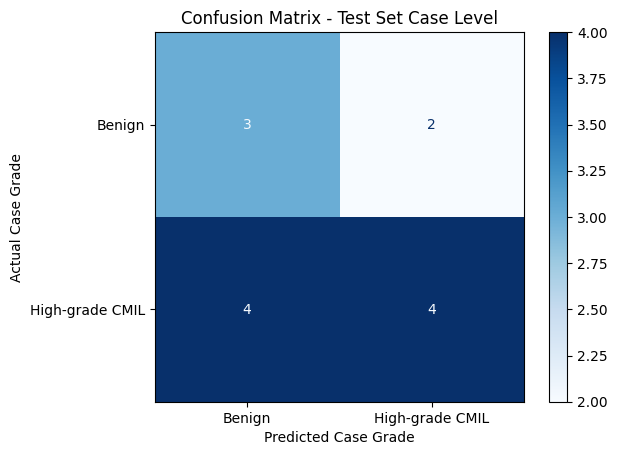

In [16]:
evaluate_model_case_level_svc(train_meta, test_meta, train_prob, test_prob, stains, k=25, tune_svc=True)